Note: the css style for this notebook lives in `~/.jupyter/custom/custom.css`.

# Purpose of notebook
I want to try out here a very simple definition of motion energy for the random dots stimulus.

I will first test this definition with 1D stimuli, and if things work out well, I'll move on to 2D stimuli.

**Notation:** Capital letter are usually reserved for vectors, whereas lower-case letters are used to denote entries within a vector. So $A=(a_i)_{1\leq i\leq n}$ for instance.

# One-dimensional stimulus
Consider a 1D grid with $N$ contiguous cells. I index time with the letter $t$. Time is discrete here and starts at 0.
## State vectors
Let $X(t)$ denote the state vector of the system at time $t$. The entries $x_i(t), 1\leq i \leq N$ of this vector contain the particle count of cell $i$.

Numerically, with 1D space, the whole "movie" can be stored in a $T+1$-by-$N$ matrix.
## Displacement vectors
Given two consecutive time steps, we define the displacement vector $\dot{X}(t):=X(t)-X(t-1)$ as the difference between the two consecutive state vectors.

If $0\leq t\leq T\in \mathbb{N}$, then $\dot{X}(t)$ may *only* be computed for $1\leq t \leq T$.

As for the state vectors. Stacking displacement row vectors on top of each other yields a *displacement matrix*.
## Movement vectors
The movement vector $M(t)$ has $N-1$ entries defined as the "right space derivative" of the displacement vector, *only taken around existing particles*. This last remark is important, as it prevents movement from being perceived/recorded around cells whose state is stationary. We thus define the entries of the movement vector as follows: $m_n(t):=\dot{x}_n(t)-\dot{x}_{n-1}(t)$ if $\dot{x}_n(t)\dot{x}_{n-1}(t)\neq 0$, and $0$ otherwise $(2\leq n \leq N, 1\leq t\leq T)$. 

Intuitively, a positive $m_i(t)$ is interpreted as rightward _movement_ between cells $i-1$ and $i$, in the time step $t-1 \to t$. Similarly, a negative entry is interpreted as leftward movement. Finally, the magnitude of the entry $|m_i(t)|$ is interpreted as the "strength" of the movement.

As for the state vectors. Stacking movement row vectors on top of each other yields a *movement matrix*.
## Motion Energy (custom definition)
I propose to define motion energy locally in time as follows.
$$ME(t):=\sum_{n=2}^N m_n(t),\qquad \forall 1\leq t\leq T$$

### Caveats
Motion energy as defined above yields debatable results in the following scenario: 2 particles moving at constant speed in the same direction, with a constant offset of 2 between them (so pattern is +-+).
## Some examples

In [1]:
#%reset
from ME_functions import *
# following two lines to be able to reimport modules on the fly after editing them
# see this post: https://stackoverflow.com/a/4111670
import sys
import importlib

# to inspect source code when needed
import inspect

In [2]:
# reload custom module if needed (because I just edited it)
# importlib.reload(sys.modules['ME_functions'])

In [3]:
# Fix grid size and time horizon
N = 10; T = 20;

### Single particle moving rightward

In [4]:
# create state matrix
stateMatrix = np.zeros((T+1,N),dtype=int)

for t in range(T+1):
    particleState = np.mod(t,N) # particle wraps around when hitting right boundary
    stateMatrix[t,particleState] = 1

In [5]:
%%capture
# example cell taken from here: https://zulko.github.io/moviepy/getting_started/working_with_matplotlib.html

ME = custom_ME(stateMatrix) # motion energy
ME_lb = np.min(ME)-1
ME_ub = np.max(ME)+1

duration = 2  # duration of clip in seconds
totFrames = T + 1 # visit each row of the state matrix once in the clip
frameRate = totFrames // duration
binSize = duration / totFrames

x = np.arange(N)+1        # 1D space
def make_frame(t):
    ax1.clear()
    tt = map_time_to_frame(t, binSize)
    xx=x[stateMatrix[np.mod(tt,T+1),:]==1]
    ax1.plot(xx, np.zeros(xx.shape), 'bo')
    ax1.set_ylim(-.5, 0.5)
    ax1.set_xlim(0, N+1)
    
    #ax2.clear()
    ax2.plot(tt+1,ME[tt],'bo')

    return mplfig_to_npimage(fig)

fig, (ax1, ax2) = plt.subplots(1, 2)
ax2.clear()
ax2.set_xlim(0,T+1)
ax2.set_ylim(ME_lb, ME_ub)

animation = VideoClip(make_frame, duration=duration)
playAnimation = animation.ipython_display(fps=frameRate, loop=True, autoplay=True, width=800)

In [6]:
playAnimation

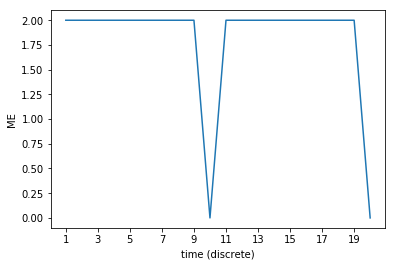

In [7]:
%matplotlib inline
ME_time = np.arange(1,T+1)
plt.plot(ME_time, custom_ME(stateMatrix))
plt.xlabel('time (discrete)')
plt.ylabel('ME')
_, _ = plt.xticks(np.arange(1,T+1,step=2))

### Two particles moving in opposite direction

In [8]:
# create state matrix
stateMatrix = np.zeros((T+1,N),dtype=int)

for t in range(T+1):
    particleState = np.mod(t,N) # particle wraps around when hitting right boundary
    stateMatrix[t,particleState] = 1
    stateMatrix[t,-particleState-1] = 1 # mirror particle

In [9]:
%%capture
# example cell taken from here: https://zulko.github.io/moviepy/getting_started/working_with_matplotlib.html
x=np.arange(N)+1  # 1D space
ME = custom_ME(stateMatrix) # motion energy
print('ME.shape ',ME.shape)
ME_lb = np.min(ME)-1
ME_ub = np.max(ME)+1

duration = 2  # duration of clip in seconds
totFrames = T + 1 # visit each row of the state matrix once in the clip
frameRate = totFrames // duration
binSize = duration / totFrames

fig, (ax1, ax2) = plt.subplots(1, 2)
ax2.clear()
ax2.set_xlim(0,T+1)
ax2.set_ylim(ME_lb, ME_ub)

animation = VideoClip(make_frame, duration=duration)
playAnimation = animation.ipython_display(fps=frameRate, loop=True, autoplay=True, width=800)

In [10]:
playAnimation

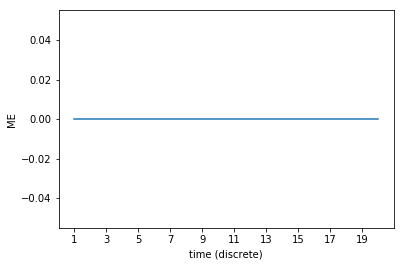

In [11]:
%matplotlib inline
ME_time = np.arange(1,T+1)
plt.plot(ME_time, custom_ME(stateMatrix))
plt.xlabel('time (discrete)')
plt.ylabel('ME')
_, _ = plt.xticks(np.arange(1,T+1,step=2))

### Two particles moving in same direction

In [12]:
# create state matrix
stateMatrix = np.zeros((T+1,N),dtype=int)
offset = 3
for t in range(T+1):
    particle1_State = np.mod(t,N) # particle wraps around when hitting right boundary
    particle2_State = np.mod(t+offset,N) # particle wraps around when hitting right boundary
    stateMatrix[t,particle1_State] = 1
    stateMatrix[t,particle2_State] = 1 # mirror particle

In [16]:
%%capture
# example cell taken from here: https://zulko.github.io/moviepy/getting_started/working_with_matplotlib.html

x=np.arange(N)+1  # 1D space
ME = custom_ME(stateMatrix) # motion energy
ME_lb = np.min(ME)-1
ME_ub = np.max(ME)+1

duration = 2  # duration of clip in seconds
totFrames = T + 1 # visit each row of the state matrix once in the clip
frameRate = totFrames // duration
binSize = duration / totFrames

fig, (ax1, ax2) = plt.subplots(1, 2)
ax2.clear()
ax2.set_xlim(0,T+1)
ax2.set_ylim(ME_lb, ME_ub)

animation = VideoClip(make_frame, duration=duration)
playAnimation = animation.ipython_display(fps=frameRate, loop=True, autoplay=True, width = 800)

In [17]:
playAnimation

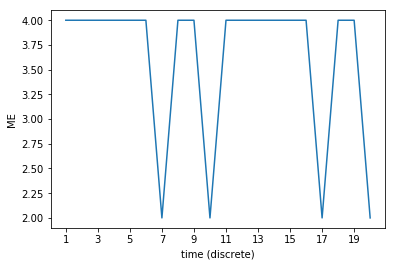

In [15]:
%matplotlib inline
ME_time = np.arange(1,T+1)
plt.plot(ME_time, custom_ME(stateMatrix))
plt.xlabel('time (discrete)')
plt.ylabel('ME')
_, _ = plt.xticks(np.arange(1,T+1,step=2))